In [20]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # Seaborn 0.13.2
from IPython.display import display
from sklearn.preprocessing import LabelEncoder

In [2]:
sampler_metrics_rel_loc = '../classical_sampling_techniques/metrics/sampler_metrics.json'
sampling_evaluator_metrics_rel_loc = '../classical_sampling_techniques/metrics/sampling_evaluator_metrics.json'
sampling_label_counts_rel_loc = '../classical_sampling_techniques/metrics/sampling_label_counts.json'

gan_metrics_rel_loc = ''
gan_evaluator_metrics_rel_loc = ''
gan_label_counts_rel_loc = ''

## Diagram 2: IDS Metrics

In [3]:
evaluator_metrics = pd.read_json(sampling_evaluator_metrics_rel_loc, orient='index')
evaluator_metrics.rename(columns={'Sampler': 'Balancer', 'Test Duration': 'Duration'}, inplace=True)
evaluator_metrics = evaluator_metrics.replace({'None': 'Unbalanced'})
# Add GAN-balanced data trained evaluator metrics when available
if gan_evaluator_metrics_rel_loc:
    gan_evaluator_metrics = pd.read_json(gan_evaluator_metrics_rel_loc, orient='index')
    evaluator_metrics = pd.concat([evaluator_metrics, gan_evaluator_metrics], axis=1)


display(evaluator_metrics)

,Balancer,Label Classes,Evaluator,Duration,Accuracy,Precision,Recall,F1
0,Unbalanced,33+1,XGBoost,2.075624,0.992896,0.769986,0.719065,0.728827
15,Unbalanced,33+1,LogisticRegression,0.106245,0.792020,0.479057,0.430702,0.420893
30,Unbalanced,33+1,Perceptron,0.082568,0.728493,0.503647,0.472640,0.421391
45,Unbalanced,33+1,AdaBoost,4.977411,0.687285,0.252317,0.290804,0.246249
60,Unbalanced,33+1,RandomForest,2.130428,0.993432,0.800865,0.724395,0.736328
...,...,...,...,...,...,...,...,...
44,ClusterCentroids,1+1,Perceptron,0.002000,0.848351,0.868787,0.847768,0.846065
59,ClusterCentroids,1+1,AdaBoost,0.084290,0.939142,0.939702,0.939058,0.939113
74,ClusterCentroids,1+1,RandomForest,0.038548,0.976388,0.976816,0.976319,0.976380
89,ClusterCentroids,1+1,DeepNeuralNetwork,0.006001,0.942951,0.945422,0.942770,0.942854


In [4]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
balancers = evaluator_metrics['Balancer'].unique().tolist()
classes = evaluator_metrics['Label Classes'].unique().tolist()
evaluators = evaluator_metrics['Evaluator'].unique().tolist()

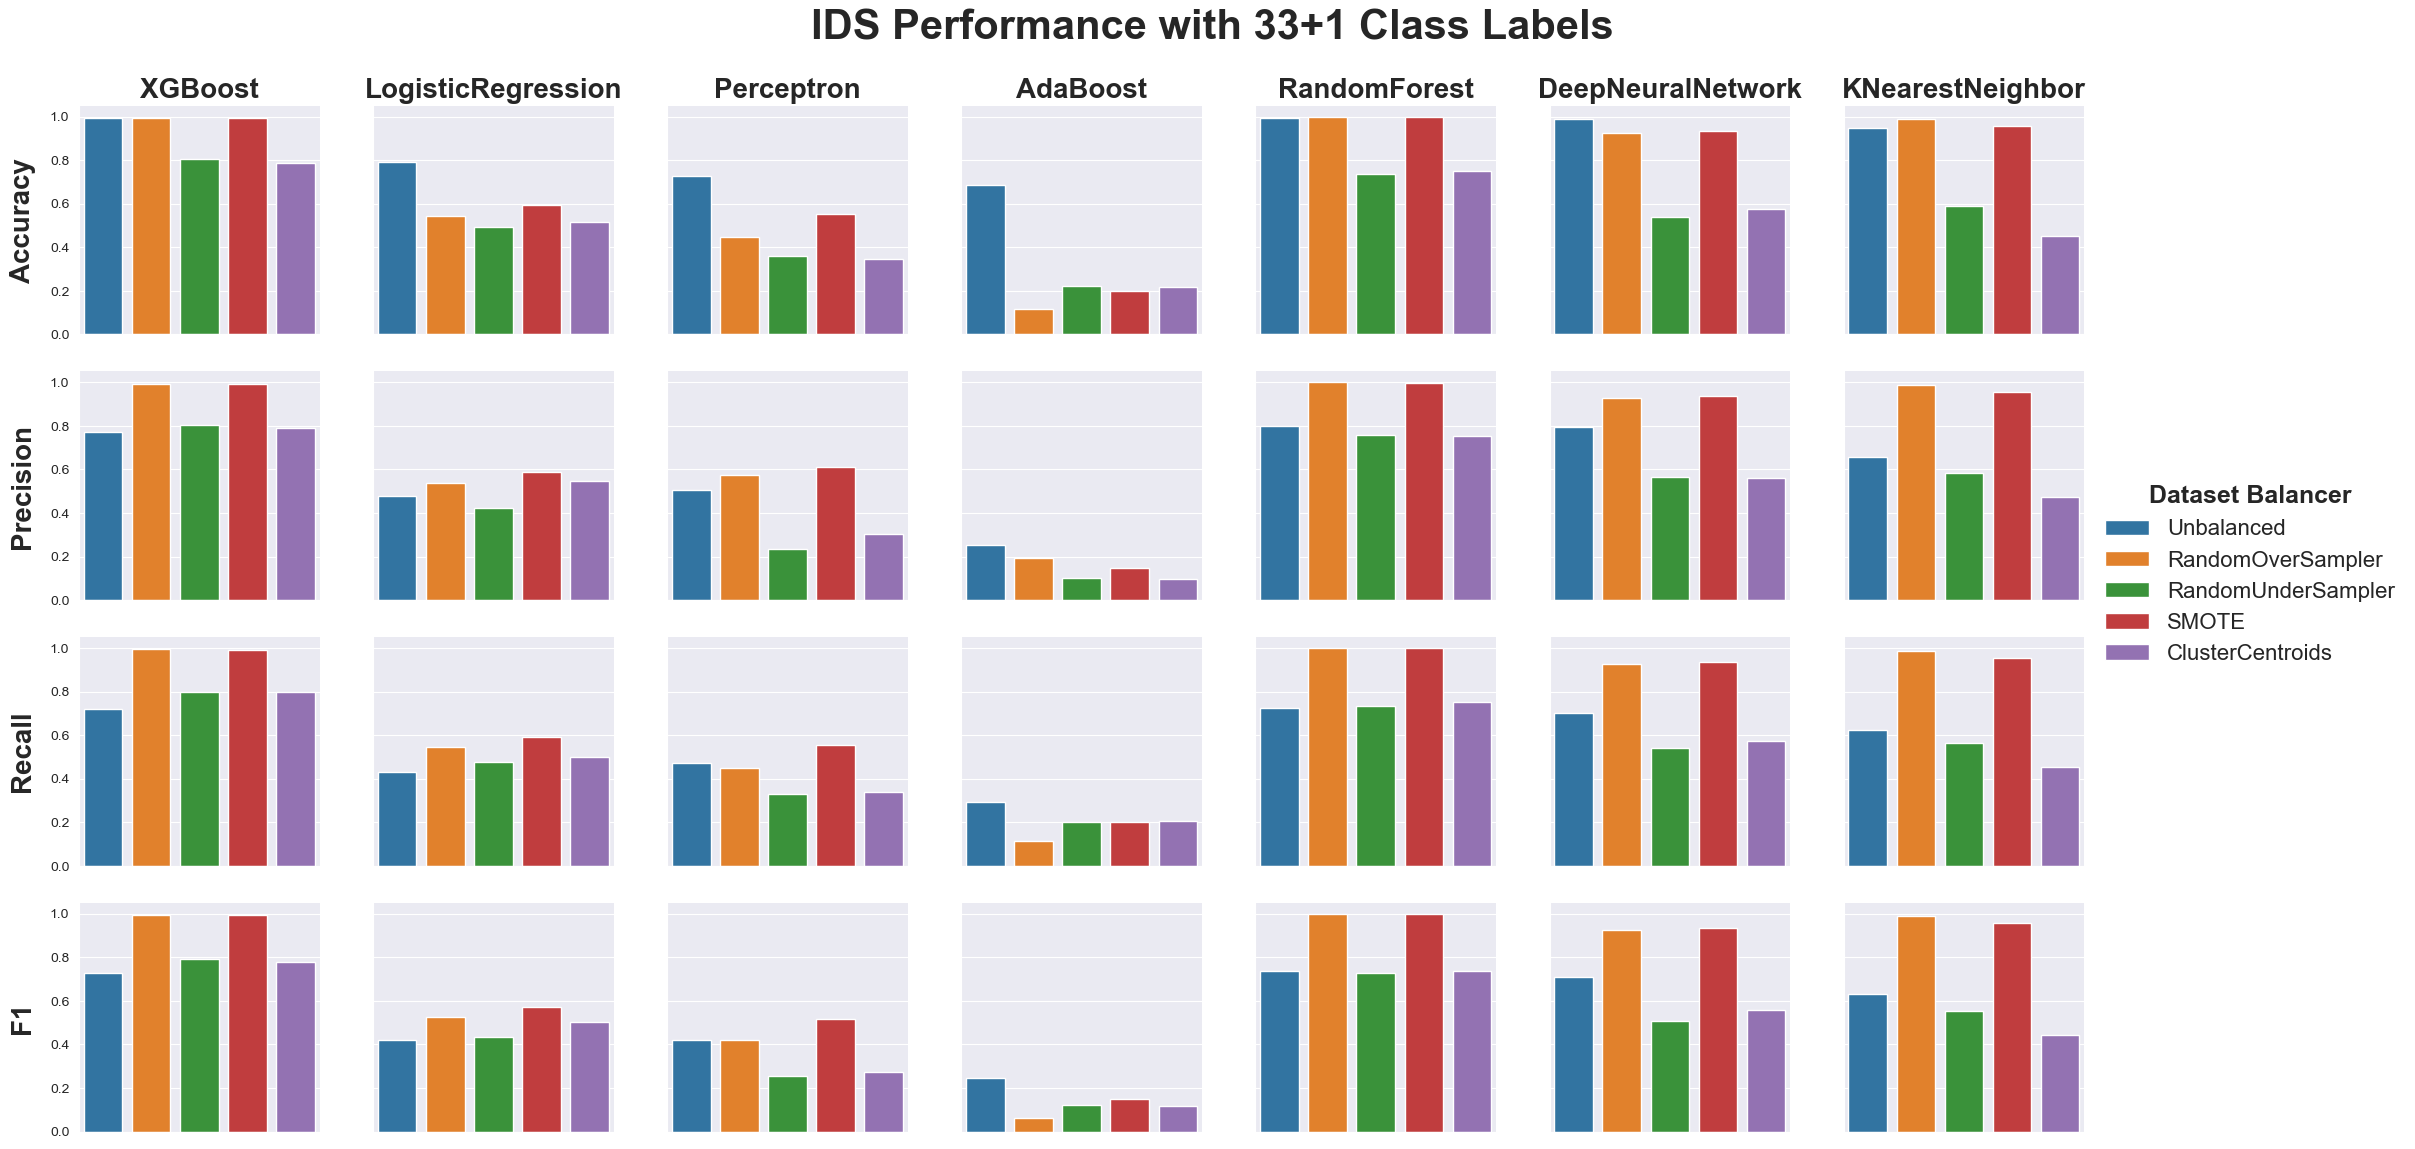

In [5]:
df_sampler = evaluator_metrics[evaluator_metrics['Label Classes'] == '33+1']
df_sampler = df_sampler[['Balancer','Evaluator', 'Accuracy', 'Precision', 'Recall', 'F1']]

# Reshape dataframe
df_melted = df_sampler.melt(id_vars=['Balancer', 'Evaluator'], value_vars=['Accuracy', 'Precision', 'Recall', 'F1'], var_name='Metric', value_name='Value')

# Create a FacetGrid
grid = sns.FacetGrid(df_melted, col="Evaluator", row="Metric", margin_titles=False, hue="Balancer")

# Map dataframe to grid
grid.map_dataframe(sns.barplot, x="Balancer", y="Value", order=balancers)

# Clean up unnecessary labels
for axis in grid.axes.flat:
    axis.set_xticklabels([])
    axis.set_title("")
    
grid.set_axis_labels("", "")

# Add row/column labels
for i, ax in enumerate(grid.axes[:, 0]):
    ax.set_ylabel(grid.row_names[i], rotation=90, fontsize='20', weight='bold', labelpad=10)

for col, ax in enumerate(grid.axes[0, :]):
    ax.set_title(grid.col_names[col], fontsize='20', weight='bold')

# Add grid title
grid.fig.suptitle(f'IDS Performance with 33+1 Class Labels', fontsize=30, weight='bold')
plt.subplots_adjust(top=0.90)

# Add legend
grid.add_legend(title='Dataset Balancer', fontsize='16')
plt.setp(grid.legend.get_title(), fontsize=18, weight='bold')

# Display graphs
plt.show()

## Diagram 3: Class Balance

In [14]:
label_count_metrics = pd.read_json(sampling_label_counts_rel_loc, orient='index')
label_count_metrics.rename(columns={'Sampler': 'Balancer'}, inplace=True)
# Get rid of samplers
label_count_metrics = label_count_metrics[label_count_metrics['Balancer'] == 'None']
# Change 'None' Balancers to 'Unbalanced'
label_count_metrics.loc[label_count_metrics['Balancer']=='None', 'Balancer'] = 'Unbalanced'

# Add GAN balance dataframe
if gan_label_counts_rel_loc:
    gan_label_counts = pd.read_json(gan_label_counts_rel_loc, orient='index') 
    label_count_metrics = pd.concat([label_count_metrics, gan_label_counts], axis=1)

classes = label_count_metrics['Label Classes'].unique().tolist()

# Make an ideal with all classes balanced to the largest major class
for i in range(3):
    row = label_count_metrics.loc[i].copy()
    labels = row.drop(['Balancer', 'Label Classes'])
    major_class_value = labels.max()
    balanced_labels = [major_class_value if label > 0 else np.NaN for label in labels.values ]
    new_row_index = len(label_count_metrics)
    new_row_values = ['Ideal', classes[i]] + balanced_labels
    label_count_metrics.loc[len(label_count_metrics)] = new_row_values

label_count_metrics

,Balancer,Label Classes,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,Unbalanced,33+1,101.0,32822.0,177.0,155.0,8532.0,859.0,214682.0,13536.0,...,22351.0,26642.0,3941.0,2918.0,71.0,2422.0,137.0,32.0,1081.0,114.0
1,Unbalanced,7+1,32822.0,403.0,1011528.0,240282.0,78778.0,10433.0,14601.0,561.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unbalanced,1+1,1356586.0,32822.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ideal,33+1,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,...,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0
4,Ideal,7+1,1011528.0,1011528.0,1011528.0,1011528.0,1011528.0,1011528.0,1011528.0,1011528.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Ideal,1+1,1356586.0,1356586.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Balancer,Label Classes,Backdoor_Malware,BenignTraffic,BrowserHijacking,CommandInjection,DDoS-ACK_Fragmentation,DDoS-HTTP_Flood,DDoS-ICMP_Flood,DDoS-ICMP_Fragmentation,...,Mirai-greip_flood,Mirai-udpplain,Recon-HostDiscovery,Recon-OSScan,Recon-PingSweep,Recon-PortScan,SqlInjection,Uploading_Attack,VulnerabilityScan,XSS
0,Unbalanced,33+1,101.0,32822.0,177.0,155.0,8532.0,859.0,214682.0,13536.0,...,22351.0,26642.0,3941.0,2918.0,71.0,2422.0,137.0,32.0,1081.0,114.0
3,Ideal,33+1,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,...,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0,214682.0


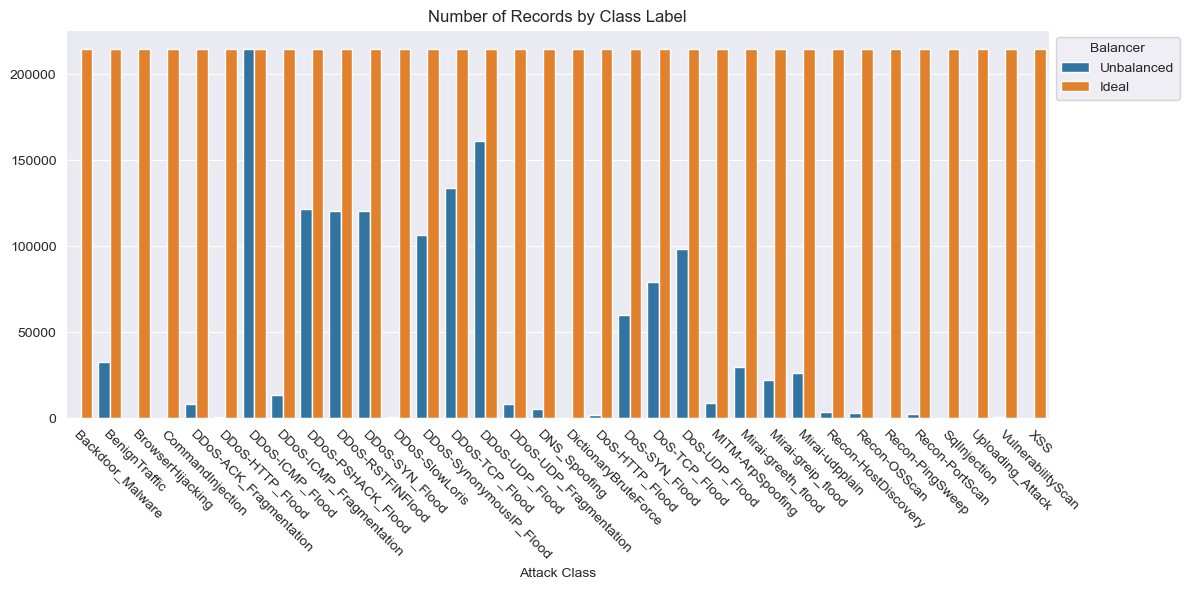

,Balancer,Label Classes,Benign,BruteForce,DDoS,DoS,Mirai,Recon,Spoofing,Web,...,24,25,26,27,28,29,30,31,32,33
1,Unbalanced,7+1,32822.0,403.0,1011528.0,240282.0,78778.0,10433.0,14601.0,561.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ideal,7+1,1011528.0,1011528.0,1011528.0,1011528.0,1011528.0,1011528.0,1011528.0,1011528.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


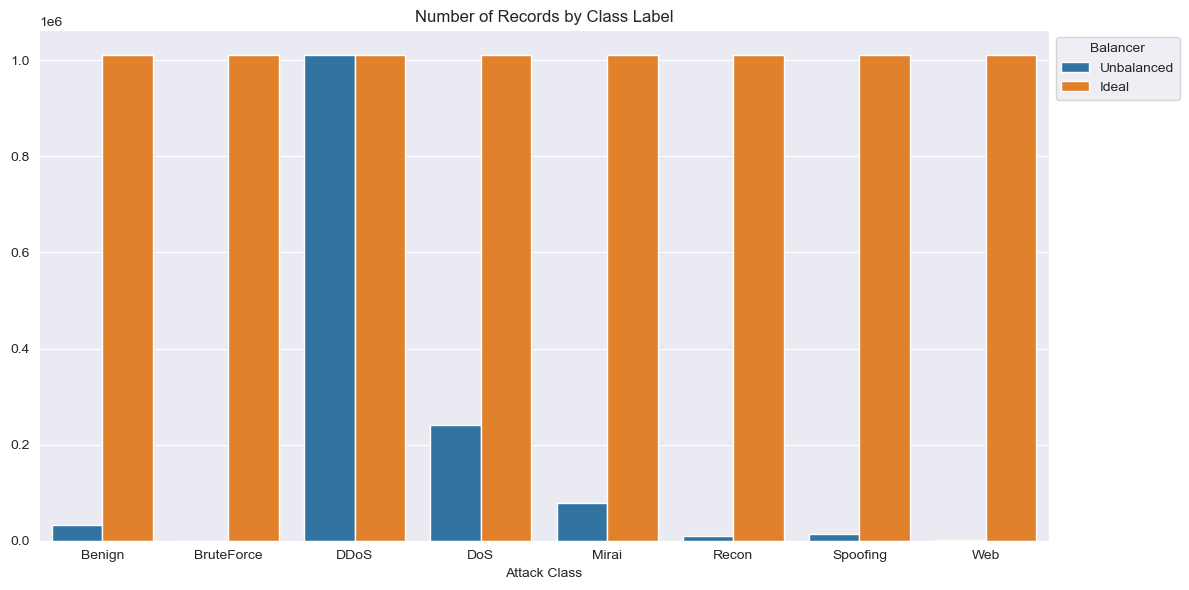

,Balancer,Label Classes,Attack,Benign,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
2,Unbalanced,1+1,1356586.0,32822.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Ideal,1+1,1356586.0,1356586.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


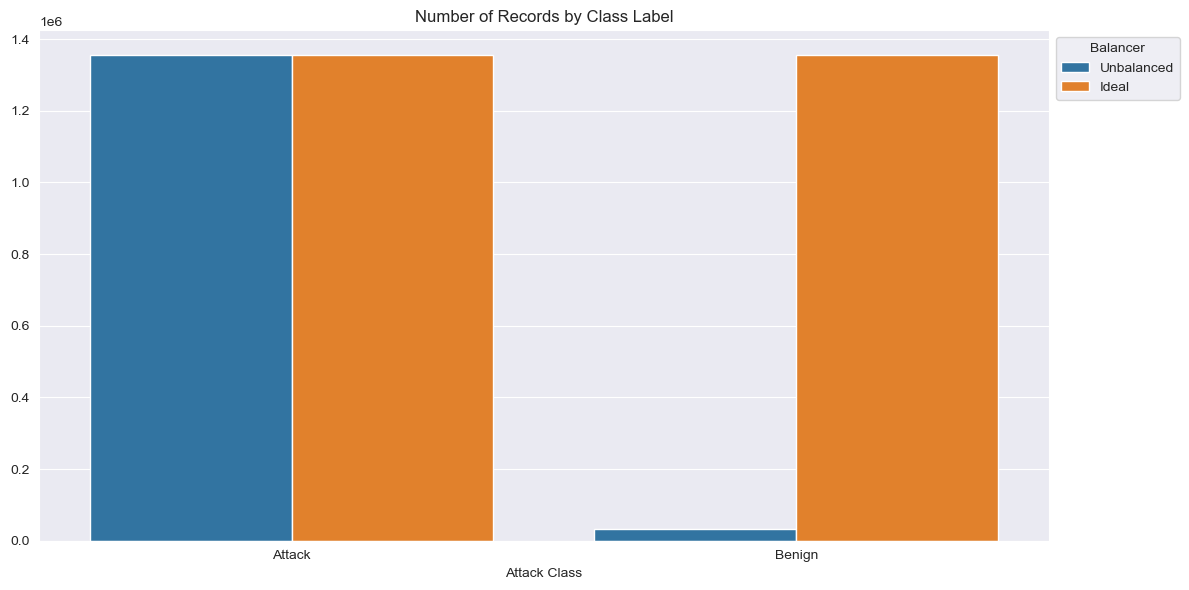

In [53]:
for label_class in ['33+1', '7+1', '1+1']:
    df_long = label_count_metrics[label_count_metrics['Label Classes'] == label_class]
    
    # Inverse encoded labels
    match label_class:
        case '33+1':
            encoder_file_relative_location = "../classical_sampling_techniques/label_encoders/full_label_encoder.pkl"
        case '7+1':
            encoder_file_relative_location = "../classical_sampling_techniques/label_encoders/group_label_encoder.pkl"
        case '1+1':
            encoder_file_relative_location = "../classical_sampling_techniques/label_encoders/binary_label_encoder.pkl"
    
    encoder = LabelEncoder()
    
    with open(encoder_file_relative_location, "rb") as encoder_file:
        encoder = pickle.load(encoder_file)
    
    encoding = {str(index): label for index, label in enumerate(encoder.classes_)}

    df_long = df_long.rename(columns=encoding)
    display(df_long)
    
    df_long = df_long.drop(['Label Classes'], axis=1)
    df_long = df_long.dropna(how= "all", axis=1)
    df_long = pd.melt(df_long, id_vars=['Balancer'], var_name='Column', value_name='Value')
    
    # Create the bar plot
    plt.figure(figsize=(12, 6))
    g = sns.barplot(data=df_long, x='Column', y='Value', hue='Balancer')
    if label_class == '33+1':
        plt.xticks(rotation=-45, ha='left', rotation_mode='anchor')
    # Customize the plot
    plt.title('Number of Records by Class Label')
    plt.xlabel('Attack Class')
    plt.ylabel('')
    plt.legend(title='Balancer', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Diagram 4: Time Metrics

In [8]:
sampler_metrics = pd.read_json(sampler_metrics_rel_loc, orient='index')
sampler_metrics.rename(columns={'Sampler': 'Balancer', 'Test Duration': 'Duration'}, inplace=True)
# Add GAN metrics when available
if gan_metrics_rel_loc:
    gan_metrics = pd.read_json(gan_metrics_rel_loc,orient='index')
    balancer_metrics = pd.concat([sampler_metrics, gan_metrics], axis=1)
else:
    balancer_metrics = sampler_metrics
    
display(balancer_metrics)


evaluator_metrics = pd.read_json(sampling_evaluator_metrics_rel_loc, orient='index')
evaluator_metrics.rename(columns={'Sampler': 'Balancer', 'Test Duration': 'Duration'}, inplace=True)
# Add GAN metrics when available
if gan_metrics_rel_loc:
    gan_metrics = pd.read_json(gan_metrics_rel_loc,orient='index')
    evaluator_metrics = pd.concat([evaluator_metrics, gan_metrics], axis=1)

evaluator_metrics = evaluator_metrics[['Balancer', 'Label Classes', 'Evaluator', 'Duration']]
display(evaluator_metrics)

,Balancer,Label Classes,Duration
5,RandomOverSampler,1+1,1.424515
3,RandomOverSampler,33+1,4.009733
4,RandomOverSampler,8+1,3.737586
2,RandomUnderSampler,1+1,0.289977
0,RandomUnderSampler,33+1,0.389955
1,RandomUnderSampler,8+1,0.313602
6,SMOTE,1+1,352.289062
8,SMOTE,33+1,2038.355977
7,SMOTE,8+1,2128.925626
11,ClusterCentroids,1+1,5053.610859


,Balancer,Label Classes,Evaluator,Duration
0,None,33+1,XGBoost,2.075624
15,None,33+1,LogisticRegression,0.106245
30,None,33+1,Perceptron,0.082568
45,None,33+1,AdaBoost,4.977411
60,None,33+1,RandomForest,2.130428
...,...,...,...,...
44,ClusterCentroids,1+1,Perceptron,0.002000
59,ClusterCentroids,1+1,AdaBoost,0.084290
74,ClusterCentroids,1+1,RandomForest,0.038548
89,ClusterCentroids,1+1,DeepNeuralNetwork,0.006001
